### Exercise 2

The goal of this exercise is to empirically validate some theoretical results of AdaBoost. For this, use the AdaBoost implementation from Assignment 9, Exercise 2. Let:

+ $f^{(t)}(x)\in \{\pm 1\}$ be AdaBoost's decision function after $t$ rounds.
+ $\varepsilon_t^* = \varepsilon_t(h_t)$ be the error rate of the base learner at round $t$.
+ $R_n\left(f^{(t)}\right)$ be the empirical risk of $f^{(t)}$.

**(a)**
Run AdaBoost using decision stumps for $T = 10$ rounds. For each $t$ print

+ the sum of the weights of misclassified examples
+ the sum of all weights $w_1^{(t+1)} + \cdots + w_n^{(t+1)}$ 
+ the value $2 \sqrt{\varepsilon_t^*(1-\varepsilon_t^*)}$.

Summarize the second and third output by their difference. 

**(b)**
Run AdaBoost using decision stumps for $T$ rounds. Plot the following metrics as a function of the number $t$ of rounds:

+ $\varepsilon_t^* = \varepsilon_t(h_t)$.
+ $R_n\left(f^{(t)}\right)$.
+ Bound of the empirical risk (see Theorem 9.6).

**(c)**
Repeat exercise (b) using two different base learners:
1. A Decision Tree classifier of depth $5$.
2. A random decision stump.

For each base learner, plot the same metrics as in part (b) as a function of the number $t$ of rounds.
Note that a random decision stump randomly selects a feature and a decision threshold.

**Remark:** 
Select an appropriate number $T$ of rounds for each ensemble classifier to ensure a clear and informative visualization. 


---
### Imports

In [1]:
import numpy as np
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
class AdaBoost:

    def __init__(self, base_learner, n_estimators=100, eta=1.):
        self.T = n_estimators
        self.eta = eta
        self.base_clf = base_learner
        self.estimators = None
    
    def fit(self, X, y):
        n_samples = X.shape[0]
        w = np.ones(n_samples)
        self.estimators = []

        self.staged_errors = np.zeros((2, self.T))
        self.staged_weights = np.zeros((2, self.T))
        
        for t in range(self.T):
            w = w / np.sum(w)                   

            h = clone(self.base_clf)  
            h.fit(X, y, sample_weight=w)        

            y_hat = h.predict(X)   
            e = 1 - accuracy_score(y, y_hat, sample_weight=w)  
            a = 0.5 * np.log((1 - e) / e) 
            a *= self.eta              

            m = 1*(y == y_hat) - 1*(y != y_hat)  
            w *= np.exp(-a * m)
            
            self.estimators.append((a, h))

            # weigthed error rate of base learner
            self.staged_errors[0,t] = e
            # empirical risk of current ensemble classifier
            self.staged_errors[1,t] = 1.-self.score(X, y)
            # sum of misclassified weights
            self.staged_weights[0,t] = np.sum(w[y_hat != y]/w.sum())
            # normalization factor Z
            self.staged_weights[1,t] = np.round(w.sum() - 2*np.sqrt(e*(1-e)),5)


        return self.estimators

    def predict(self, X):
        pred = np.zeros(X.shape[0])
        for a, h in self.estimators:
            pred += a * h.predict(X)
        return np.sign(pred)
    
    def score(self, X, y):
        y_hat = self.predict(X)  
        return accuracy_score(y, y_hat)
    
    def staged_ensemble_errors(self):
        return self.staged_errors[1]
    
    def staged_base_errors(self):
        return self.staged_errors[0]
    
    def staged_w(self):
        return self.staged_weights[0]
    
    def staged_Z(self):
        return self.staged_weights[1]

---
### Random Decision Stump

In [3]:
from sklearn.base import BaseEstimator
class RandStump(BaseEstimator):

    def __init__(self, test=0, theta=0):
        self.test = test
        self.theta = theta 
        
    def fit(self, X, y, sample_weight=None):
        n_features = X.shape[1]

        test = np.random.randint(n_features)
        min_val = X[:,test].min()
        max_val = X[:,test].max()
        theta = min_val + (max_val-min_val)*np.random.rand()

        self.test = test
        self.theta = theta

    def predict(self, X):
        y_hat = 2*(X[:,self.test] >= self.theta) - 1
        return y_hat
    
    def score(self, X, y):
        y_hat = self.predict(X)  
        return accuracy_score(y, y_hat)    

---
### Run Function

In [4]:
def run(clf, X, y):
    clf.fit(X, y)
    ens_err = clf.staged_ensemble_errors()
    bas_err = clf.staged_base_errors()
    bound = np.exp(-2*np.cumsum((bas_err-0.5)**2))

    n = np.arange(1, len(ens_err)+1)    
    plt.plot(n, ens_err, lw=2, label='ensemble')
    plt.plot(n, bas_err, lw=2, label='base')
    plt.plot(n, bound, lw=2, label='bound')
    plt.plot(n, np.zeros_like(n)+0.5, color='tab:gray', linestyle='--')
    plt.legend()
    plt.show()

---
### Dataset

In [5]:

X, y = make_classification(n_samples=1000, n_features=20, 
                           n_informative=8, n_clusters_per_class=4)
y = 2*y - 1


---
### (a)

In [6]:
clf = AdaBoost(DecisionTreeClassifier(max_depth=1), n_estimators=10)
clf.fit(X, y)
print("weights:", clf.staged_w())
print("delta Z:", clf.staged_Z())

weights: [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
delta Z: [ 0.  0. -0.  0.  0.  0. -0.  0.  0.  0.]


---
### (b)

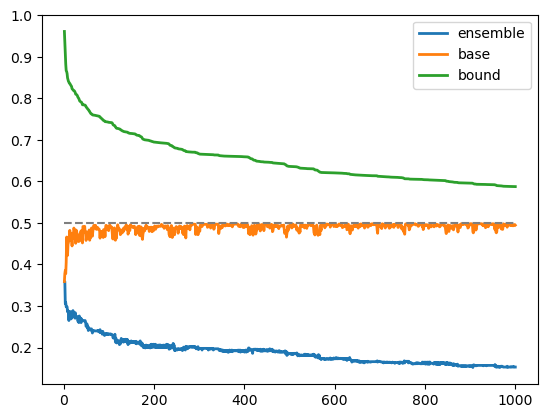

In [9]:
clf = AdaBoost(DecisionTreeClassifier(max_depth=1), n_estimators=1000)
run(clf, X, y)

---
### (c)

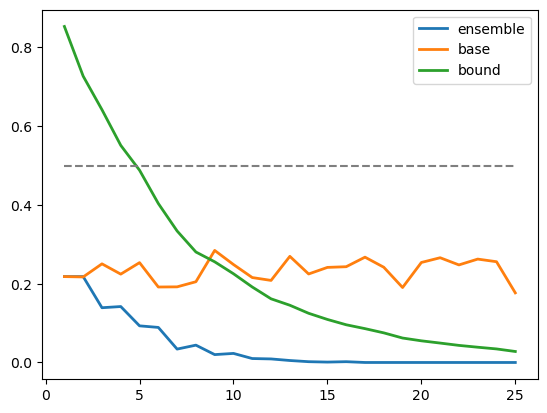

In [10]:
# Decision Tree with depth 5
clf = AdaBoost(DecisionTreeClassifier(max_depth=5), n_estimators=25)
run(clf, X, y)

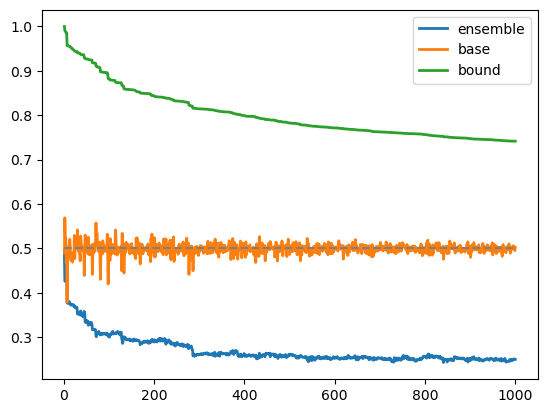

In [12]:
# random decision stump
clf = AdaBoost(RandStump(), n_estimators=1000)
run(clf, X, y)